In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import netCDF4
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


#  Data Loading

In [2]:
summary_dir = '/Trex/test_case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/summary'
# summary_dir = '/Users/yguo/DataSpellProjects/hw/uhi'


# merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables.feather')
merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables_with_location_ID_event_ID.feather')

local_hour_adjusted_df = pd.read_feather(merged_feather_path)
local_hour_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58245960 entries, 8945088 to 56705927
Data columns (total 73 columns):
 #   Column           Dtype         
---  ------           -----         
 0   index            int64         
 1   time             datetime64[ns]
 2   lat              float32       
 3   lon              float32       
 4   APPAR_TEMP       float32       
 5   APPAR_TEMP_R     float32       
 6   APPAR_TEMP_U     float32       
 7   EFLX_LH_TOT      float32       
 8   EFLX_LH_TOT_R    float32       
 9   EFLX_LH_TOT_U    float32       
 10  FGR              float32       
 11  FGR_R            float32       
 12  FGR_U            float32       
 13  FIRA             float32       
 14  FIRA_R           float32       
 15  FIRA_U           float32       
 16  FIRE             float32       
 17  FIRE_R           float32       
 18  FIRE_U           float32       
 19  FLDS             float32       
 20  FSA              float32       
 21  FSA_R            float32    

In [3]:
location_ID_path = os.path.join(summary_dir, 'location_IDs.nc')
location_ID_ds = xr.open_dataset(location_ID_path, engine='netcdf4')

In [4]:
location_ID_ds

<xarray.Dataset> Size: 444kB
Dimensions:      (lon: 288, lat: 192)
Coordinates:
  * lon          (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Data variables:
    location_ID  (lat, lon) int64 442kB ...

## Feature list loading

In [5]:
df_daily_vars = pd.read_excel('../Data/hourlyDataSchema.xlsx')
daily_vars =df_daily_vars.loc[df_daily_vars['X_vars2'] == 'Y', 'Variable']
daily_var_lst = daily_vars.tolist()
daily_var_lst

['EFLX_LH_TOT',
 'FGR',
 'FIRA',
 'FLDS',
 'FSA',
 'FSDS',
 'FSH',
 'PBOT',
 'Q2M',
 'TSA',
 'U10']

In [6]:
df_daily_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Variable       57 non-null     object 
 1   Long Name      57 non-null     object 
 2   Units          53 non-null     object 
 3   Cell Methods   52 non-null     object 
 4   Fill Value     57 non-null     object 
 5   Missing Value  57 non-null     object 
 6   X_vars         46 non-null     object 
 7   X_vars2        13 non-null     object 
 8   X_selected     11 non-null     object 
 9   Notes          0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 4.6+ KB


In [7]:
def add_long_name(input_df, join_column='Feature', df_daily_vars=df_daily_vars):
    # Perform a left join on the input dataframe using the specified join column
    # This will add all columns from df_daily_vars to input_df where the join_column matches the 'Variable' in df_daily_vars
    merged_df = pd.merge(input_df, df_daily_vars[['Variable', 'Long Name']], left_on=join_column, right_on='Variable', how='left')

    # Since the 'Variable' column from df_daily_vars will be redundant, we can drop it
    merged_df.drop(columns=['Variable'], inplace=True)

    # Return the modified DataFrame
    return merged_df


##  Day Night mask

In [8]:
# Step 1: Define masks for daytime and nighttime
daytime_mask = local_hour_adjusted_df['local_hour'].between(8, 16)
nighttime_mask = (local_hour_adjusted_df['local_hour'].between(20, 24) |
                  local_hour_adjusted_df['local_hour'].between(0, 4))


In [9]:
daytime_uhi_diff = local_hour_adjusted_df[daytime_mask]
X_day = daytime_uhi_diff[daily_var_lst]
y_day = daytime_uhi_diff['UHI_diff']
X_day.info()
y_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21842235 entries, 8947194 to 56695507
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   EFLX_LH_TOT  float32
 1   FGR          float32
 2   FIRA         float32
 3   FLDS         float32
 4   FSA          float32
 5   FSDS         float32
 6   FSH          float32
 7   PBOT         float32
 8   Q2M          float32
 9   TSA          float32
 10  U10          float32
dtypes: float32(11)
memory usage: 1.1 GB
<class 'pandas.core.series.Series'>
Index: 21842235 entries, 8947194 to 56695507
Series name: UHI_diff
Non-Null Count     Dtype  
--------------     -----  
21842235 non-null  float32
dtypes: float32(1)
memory usage: 250.0 MB


In [10]:
nighttime_uhi_diff = local_hour_adjusted_df[nighttime_mask]
X_night = nighttime_uhi_diff[daily_var_lst]
y_night = nighttime_uhi_diff['UHI_diff']

X_night.info()
y_night.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21842235 entries, 8945250 to 56705927
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   EFLX_LH_TOT  float32
 1   FGR          float32
 2   FIRA         float32
 3   FLDS         float32
 4   FSA          float32
 5   FSDS         float32
 6   FSH          float32
 7   PBOT         float32
 8   Q2M          float32
 9   TSA          float32
 10  U10          float32
dtypes: float32(11)
memory usage: 1.1 GB
<class 'pandas.core.series.Series'>
Index: 21842235 entries, 8945250 to 56705927
Series name: UHI_diff
Non-Null Count     Dtype  
--------------     -----  
21842235 non-null  float32
dtypes: float32(1)
memory usage: 250.0 MB


#  Getting sense of relationships of feature and label

##  Linear beta, Slope CI and P value for each feature

In [79]:
from scipy.stats import linregress
import pandas as pd
import numpy as np

def feature_linear_slope(df, feature_name, label, confidence_level=0.95):
    # Compute linear regression and get the slope, intercept, r-value, p-value, and standard error
    slope, _, _, p_value, stderr = linregress(df[feature_name], df[label])
    # Calculate the critical value for the given confidence level
    t_value = np.abs(np.percentile(np.random.standard_t(df[feature_name].shape[0] - 2, 100000), [(1-confidence_level)/2, 1-(1-confidence_level)/2]))[1]
    # Calculate the margin of error
    margin_of_error = t_value * stderr
    return slope, margin_of_error, p_value

def combine_slopes(daytime_df, nighttime_df, features, labels=['UHI', 'UHI_diff'], confidence_level=0.95):
    # Initialize a dictionary to hold the data
    data = {}

    # Loop over each feature
    for feature in features:
        # List to store slopes and confidence intervals for current feature across all conditions
        slopes_with_intervals = []
        
        # Collect slopes and confidence intervals for each dataset and label
        for df, time in [(daytime_df, 'Day'), (nighttime_df, 'Night')]:
            for label in labels:
                slope, margin_of_error, p_value = feature_linear_slope(df, feature, label, confidence_level)
                # Create the slope with confidence interval and p-value string
                slope_with_interval = f"{slope:.6f} (± {margin_of_error:.6f}, P: {p_value:.6f})"
                slopes_with_intervals.append(slope_with_interval)
        
        # Store the slopes with confidence intervals in the dictionary, with the feature as the key
        data[feature] = slopes_with_intervals

    # Convert the dictionary to DataFrame
    columns = [f'{time}_{label}_slope' for time in ['Day', 'Night'] for label in labels]
    results_df = pd.DataFrame(data, index=columns).transpose()

    return results_df

feature_names = day_full_pool.get_feature_names()
results_df = combine_slopes(daytime_uhi_diff, nighttime_uhi_diff, feature_names)
results_df.sort_values('Day_UHI_slope', ascending=False)



,Day_UHI_slope,Day_UHI_diff_slope,Night_UHI_slope,Night_UHI_diff_slope
U10,"0.125518 (± 0.000296, P: 0.000000)","-0.004366 (± 0.000162, P: 0.000000)","-0.107262 (± 0.000254, P: 0.000000)","-0.052122 (± 0.000136, P: 0.000000)"
TSA,"0.063322 (± 0.000100, P: 0.000000)","-0.002826 (± 0.000056, P: 0.000000)","0.002065 (± 0.000080, P: 0.000000)","-0.002828 (± 0.000043, P: 0.000000)"
FIRA,"0.005498 (± 0.000007, P: 0.000000)","-0.000490 (± 0.000004, P: 0.000000)","0.004344 (± 0.000013, P: 0.000000)","0.001776 (± 0.000007, P: 0.000000)"
FSH,"0.003007 (± 0.000004, P: 0.000000)","0.000070 (± 0.000002, P: 0.000000)","-0.007477 (± 0.000020, P: 0.000000)","-0.004385 (± 0.000011, P: 0.000000)"
FSDS,"0.001311 (± 0.000002, P: 0.000000)","0.000070 (± 0.000001, P: 0.000000)","0.014698 (± 0.000157, P: 0.000000)","0.005237 (± 0.000085, P: 0.000000)"
FSA,"0.001189 (± 0.000002, P: 0.000000)","0.000118 (± 0.000001, P: 0.000000)","0.018560 (± 0.000196, P: 0.000000)","0.006697 (± 0.000107, P: 0.000000)"
FGR,"0.001145 (± 0.000006, P: 0.000000)","-0.000253 (± 0.000003, P: 0.000000)","-0.000711 (± 0.000012, P: 0.000000)","0.000036 (± 0.000006, P: 0.000000)"
Q2M,"-41.801117 (± 0.058606, P: 0.000000)","-2.283894 (± 0.033557, P: 0.000000)","-20.178095 (± 0.052766, P: 0.000000)","-5.672579 (± 0.028833, P: 0.000000)"
FLDS,"-0.001805 (± 0.000013, P: 0.000000)","0.000919 (± 0.000007, P: 0.000000)","-0.002580 (± 0.000009, P: 0.000000)","-0.001403 (± 0.000005, P: 0.000000)"
EFLX_LH_TOT,"-0.001010 (± 0.000004, P: 0.000000)","0.000537 (± 0.000002, P: 0.000000)","-0.000811 (± 0.000019, P: 0.000000)","-0.000119 (± 0.000010, P: 0.000000)"


## Some observations, thoughts and questions.

In [80]:
# note that for UHI ~ U10 slope, the daytime slope is positive and the nighttime slope is negative
# however for UHI_diff ~ U10 slope, the daytime and nighttime slope are both negative, which is inconsistent with (Dan Li et al. 2016 Changes in Wind Speed under Heat Waves Enhance Urban Heat Islands in the Beijing Metropolitan Area)

In [82]:
daytime_uhi_diff[feature_names].describe()

,EFLX_LH_TOT,FGR,FIRA,FLDS,FSA,FSDS,FSH,PBOT,Q2M,TSA,U10
count,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07
mean,1.449397e+02,1.063166e+02,1.267803e+02,4.029256e+02,5.025129e+02,6.045804e+02,1.244846e+02,9.589119e+04,1.445100e-02,3.066066e+02,3.014395e+00
std,1.044662e+02,6.626863e+01,5.454506e+01,3.377031e+01,1.784967e+02,2.178960e+02,9.667429e+01,6.720920e+03,6.936407e-03,2.806667e+01,1.384413e+00
min,-3.654014e+02,-3.765916e+02,-9.234869e+01,2.350358e+02,7.515556e-01,8.976600e-01,-2.186229e+02,7.386439e+04,4.733410e-04,2.682860e+02,4.881164e-01
25%,5.302910e+01,5.358280e+01,8.354679e+01,3.827422e+02,3.674444e+02,4.413369e+02,4.265466e+01,9.428065e+04,8.293897e-03,3.039807e+02,1.944991e+00
50%,1.205087e+02,1.040666e+02,1.176701e+02,4.092747e+02,5.195067e+02,6.250395e+02,1.094941e+02,9.742280e+04,1.457194e-02,3.062955e+02,2.740048e+00
75%,2.260686e+02,1.556890e+02,1.654784e+02,4.262935e+02,6.446540e+02,7.811445e+02,1.911520e+02,9.941032e+04,2.002058e-02,3.088826e+02,3.803425e+00
max,7.874184e+02,8.632037e+02,4.043884e+02,5.448807e+02,1.206133e+03,1.438224e+03,7.672695e+02,1.027793e+05,8.981472e-02,3.321967e+02,1.634675e+01


#   Using CatBoost model to study feature behaviours 

##  Functions to create model and graph

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap

def train_and_evaluate(time_uhi_diff, df_daily_vars):
    daily_vars =df_daily_vars.loc[df_daily_vars['X_vars2'] == 'Y', 'Variable']
    daily_var_lst = daily_vars.tolist()
    # Select features and target
    X = time_uhi_diff[daily_var_lst]
    y = time_uhi_diff['UHI_diff']

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_pool = Pool(X_train, y_train)
    validation_pool = Pool(X_val, y_val)

    # Train the final model with all columns on selected features after feature selection
    model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.03,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        task_type='GPU',
        early_stopping_rounds=100,
        verbose=False
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val),
                       use_best_model=True, early_stopping_rounds=50, 
                       plot=True, 
                       verbose=False)
    return model

def importance_plot(model, validation_pool, df_daily_vars):
    # Get long_feature_names
    feature_names = validation_pool.get_feature_names()
    feature_name_mapping = pd.Series(df_daily_vars['Long Name'].values, index=df_daily_vars['Variable']).to_dict()
    long_feature_names = [feature_name_mapping.get(name, "Unknown Feature") for name in feature_names]
    # Calculate SHAP values    
    explainer = shap.TreeExplainer(model, feature_names=long_feature_names)
    shap_values = explainer.shap_values(validation_pool)
    mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
    # Normalize the SHAP values so that they sum to one
    total = mean_abs_shap_values.sum()
    normalized_shap_values = mean_abs_shap_values / total
    # Plot the SHAP values for the first instance in the validation dataset
    shap.waterfall_plot(shap.Explanation(normalized_shap_values, base_values=explainer.expected_value,
                                         data=validation_pool.get_features()[0],
                                         feature_names=validation_pool.get_feature_names()))
    
    shap.plots.waterfall(shap_values)


##  Train both night and day models

In [13]:
night_model = train_and_evaluate(nighttime_uhi_diff, df_daily_vars=df_daily_vars)
day_model = train_and_evaluate(daytime_uhi_diff, df_daily_vars=df_daily_vars)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
#saving models
night_model.save_model('/home/jguo/research/hw_global/results/model_night_model_lr003_it3000_depth6.cbm')
day_model.save_model('/home/jguo/research/hw_global/results/model_day_model_lr003_it3000_depth6.cbm')

## Feature importance

In [15]:
day_full_pool = Pool(X_day, y_day)
night_full_pool = Pool(X_night, y_night)

In [16]:
# day_full_pool = Pool(X_day, y_day)
# day_shap_interations = day_model.get_feature_importance(day_full_pool, type='ShapInteractionValues')
# day_shap_interations

In [17]:
def get_ordered_feature_importance(model: CatBoostRegressor, pool, type='FeatureImportance'):
    if type == 'FeatureImportance':
        feature_importances = model.get_feature_importance()
    else:
        feature_importances = model.get_feature_importance(pool, type=type)
    feature_importance_df = pd.DataFrame({'Feature': pool.get_feature_names(), 'Importance': feature_importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    feature_importance_df = add_long_name(feature_importance_df, join_column='Feature')
    return feature_importance_df

In [18]:
# Get feature importance
get_ordered_feature_importance(day_model, day_full_pool)


,Feature,Importance,Long Name
0,U10,16.955792,10-m wind
1,Q2M,16.288015,2m specific humidity
2,FSH,15.669898,sensible heat not including correction for lan...
3,EFLX_LH_TOT,13.516576,total latent heat flux [+ to atm]
4,PBOT,7.960314,atmospheric pressure at surface (downscaled to...
5,FIRA,7.735166,net infrared (longwave) radiation
6,TSA,6.983964,2m air temperature
7,FGR,6.776036,heat flux into soil/snow including snow melt a...
8,FLDS,3.661798,atmospheric longwave radiation (downscaled to ...
9,FSDS,3.596110,atmospheric incident solar radiation


In [19]:
# Get feature importance
get_ordered_feature_importance(day_model, day_full_pool, type='LossFunctionChange')


,Feature,Importance,Long Name
0,U10,0.021065,10-m wind
1,Q2M,0.011413,2m specific humidity
2,FGR,0.008309,heat flux into soil/snow including snow melt a...
3,FSH,0.008036,sensible heat not including correction for lan...
4,EFLX_LH_TOT,0.006517,total latent heat flux [+ to atm]
5,TSA,0.004192,2m air temperature
6,FIRA,0.004065,net infrared (longwave) radiation
7,PBOT,0.003969,atmospheric pressure at surface (downscaled to...
8,FSDS,0.003403,atmospheric incident solar radiation
9,FLDS,0.001394,atmospheric longwave radiation (downscaled to ...


In [20]:
get_ordered_feature_importance(night_model, night_full_pool)  

,Feature,Importance,Long Name
0,FSH,24.536583,sensible heat not including correction for lan...
1,U10,21.382762,10-m wind
2,Q2M,10.458553,2m specific humidity
3,EFLX_LH_TOT,9.611095,total latent heat flux [+ to atm]
4,PBOT,9.533523,atmospheric pressure at surface (downscaled to...
5,FIRA,8.655060,net infrared (longwave) radiation
6,TSA,7.938541,2m air temperature
7,FGR,4.911458,heat flux into soil/snow including snow melt a...
8,FLDS,2.821849,atmospheric longwave radiation (downscaled to ...
9,FSA,0.116786,absorbed solar radiation


In [21]:
get_ordered_feature_importance(night_model, night_full_pool, type='LossFunctionChange')

,Feature,Importance,Long Name
0,FSH,0.034672,sensible heat not including correction for lan...
1,U10,0.026548,10-m wind
2,TSA,0.005784,2m air temperature
3,Q2M,0.004702,2m specific humidity
4,FGR,0.003528,heat flux into soil/snow including snow melt a...
5,PBOT,0.003315,atmospheric pressure at surface (downscaled to...
6,FIRA,0.003298,net infrared (longwave) radiation
7,EFLX_LH_TOT,0.003134,total latent heat flux [+ to atm]
8,FLDS,0.002028,atmospheric longwave radiation (downscaled to ...
9,FSA,0.000047,absorbed solar radiation


In [22]:
import catboost
from catboost import *
import shap
shap.initjs() 

## Summary beeswarm plot

### Daytime model

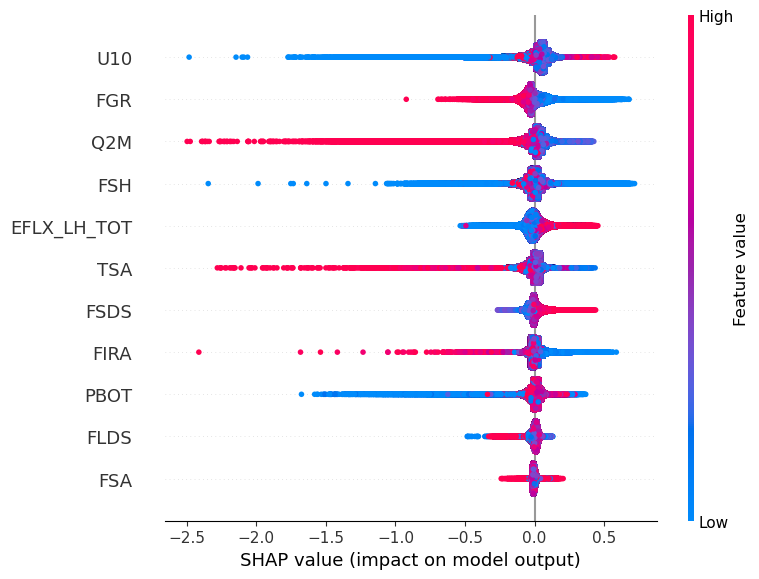

In [23]:
shap_values = day_model.get_feature_importance(day_full_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_day)

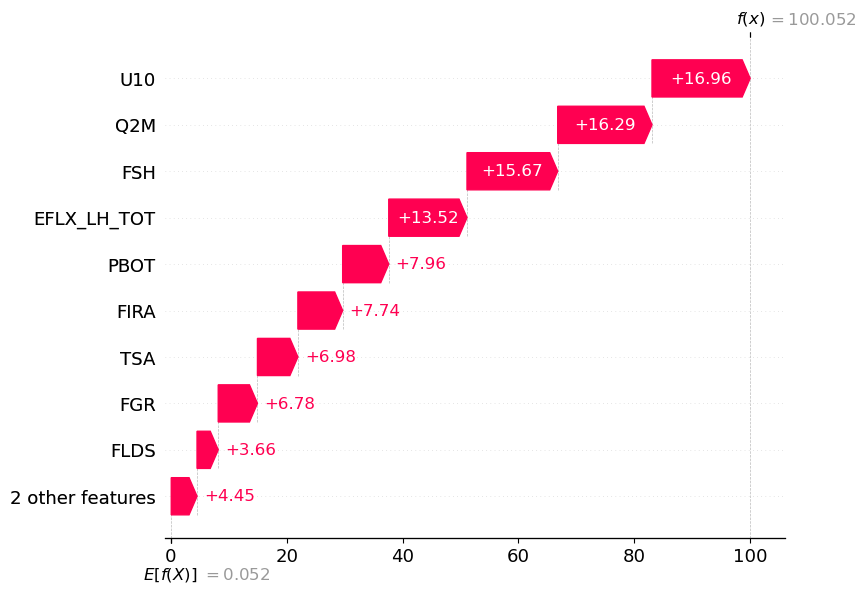

In [94]:
day_feature_importances = day_model.get_feature_importance()
shap.waterfall_plot(shap.Explanation(day_feature_importances, base_values=expected_value, 
                                    #  data=night_shap_values, 
                                     feature_names=day_full_pool.get_feature_names()))

###  Nighttime model

In [89]:
night_shap_values = night_model.get_feature_importance(night_full_pool, type='ShapValues')

night_expected_value = night_shap_values[0,-1]
night_shap_values = night_shap_values[:,:-1]

# shap.summary_plot(night_shap_values, X_night)

In [95]:
shap.summary_plot(night_shap_values, X_night)

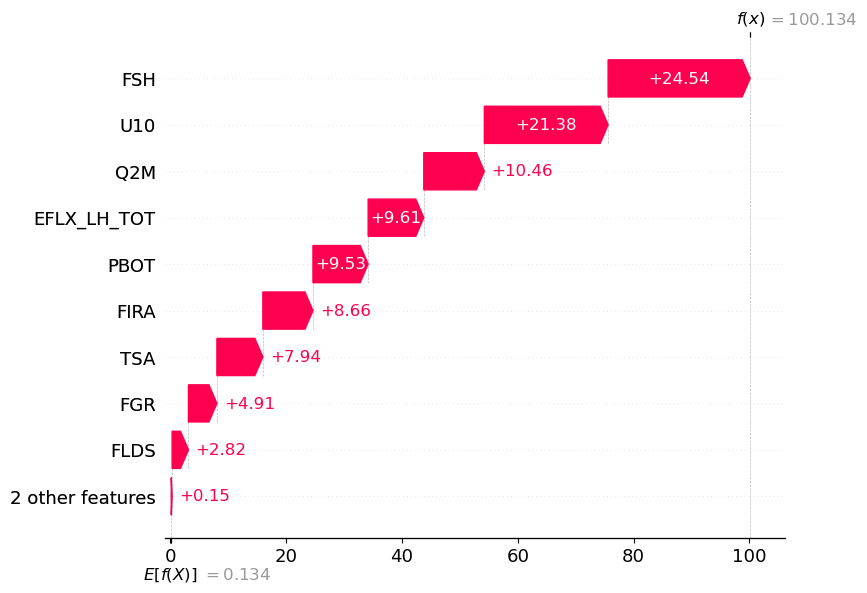

In [93]:
night_feature_importances = night_model.get_feature_importance()
shap.waterfall_plot(shap.Explanation(night_feature_importances, base_values=night_expected_value, 
                                    #  data=night_shap_values, 
                                     feature_names=night_full_pool.get_feature_names()))

In [27]:
print(day_full_pool.get_feature_names())
shap_values[0,:]

['EFLX_LH_TOT', 'FGR', 'FIRA', 'FLDS', 'FSA', 'FSDS', 'FSH', 'PBOT', 'Q2M', 'TSA', 'U10']


array([-0.04736953,  0.04561276,  0.00143372,  0.02197716,  0.01106016,
       -0.04124518,  0.00705004,  0.00842038,  0.02051504,  0.08836136,
       -0.08318866])

In [28]:
print(sum(shap_values[0,:]))

0.032627257275306215


In [32]:
q2m_mean = local_hour_adjusted_df['Q2M'].mean()

In [39]:
local_hour_adjusted_df.groupby(local_hour_adjusted_df['Q2M'] > 0)['UHI_diff'].mean()

Q2M
True    0.10877
Name: UHI_diff, dtype: float32

##  Dependence plots for all feature pairs

In [ ]:
import shap
import matplotlib.pyplot as plt

# Assuming your model variable is stored as 'model'
# Calculate SHAP values for the validation data
shap_values = day_model.get_feature_importance(validation_pool, type='ShapValues')

# Remove the last column from shap_values which is the base value
shap_values = shap_values[:,:-1]

# List of features for pairwise dependence plots
features = X_train.columns.tolist()

# Loop over each pair of features and create a dependence plot
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        shap.dependence_plot((features[i], features[j]), shap_values, X_val, interaction_index=features[j])
        plt.title(f'Dependence Plot: {features[i]} vs {features[j]}')
        plt.show()


In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X['U10'], y)
plt.title('Plot of ColumnX vs ColumnY')
plt.xlabel('ColumnX')
plt.ylabel('ColumnY')
plt.grid(True)
plt.show()